# Проект Телеком

# Описание проекта

В данном проекте нам необходимо на основе полученных данных построить модель машинного обучения, которая будет прогназировать отток клиетов. 

Построить несколько моделей и выбрать лучшю из них

Добиться значений метрики *AUC-ROC* равной 0.89

# Загрузка данных

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from catboost import Pool, cv
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import (
    
    RandomizedSearchCV,
    train_test_split
)
from sklearn.pipeline import make_pipeline

import warnings

warnings.filterwarnings("ignore")
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

In [3]:
contract = pd.read_csv('/datasets/final_provider/contract.csv')
personal = pd.read_csv('/datasets/final_provider/personal.csv')
internet = pd.read_csv('/datasets/final_provider/internet.csv')
phone = pd.read_csv('/datasets/final_provider/phone.csv')

In [4]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


<AxesSubplot:>

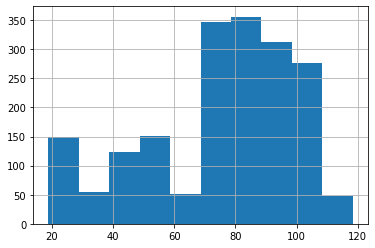

In [5]:
c_non = contract.loc[contract['EndDate'] != 'No','EndDate'].index
c_non
contract['MonthlyCharges'][c_non].hist()

<AxesSubplot:>

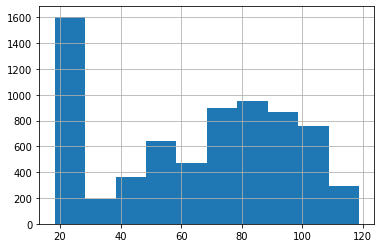

In [6]:
contract['MonthlyCharges'].hist()

<AxesSubplot:>

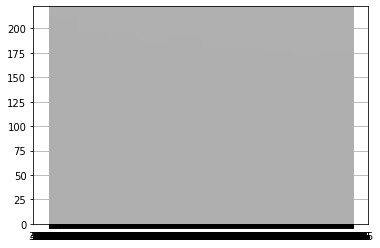

In [7]:
contract['TotalCharges'][c_non].hist()

In [8]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [9]:
contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'], errors='coerce') 
contract.describe()


,MonthlyCharges,TotalCharges
count,7043.000000,7032.000000
mean,64.761692,2283.300441
std,30.090047,2266.771362
min,18.250000,18.800000
25%,35.500000,401.450000
50%,70.350000,1397.475000
75%,89.850000,3794.737500
max,118.750000,8684.800000


In [10]:
contract[contract['TotalCharges'].isna()]


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,NaN
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,NaN
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,NaN
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,NaN
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,NaN
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,NaN
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,NaN
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,NaN
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,NaN
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,NaN


In [11]:
contract['TotalCharges'][5218] = contract['MonthlyCharges'][5218]
b = contract[contract['TotalCharges'].isna()].index
for ss in b:
    contract['TotalCharges'][ss] = contract['MonthlyCharges'][ss]


In [12]:
contract[contract['TotalCharges'].isna()].count()

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

In [13]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   float64
dtypes: float64(2), object(6)
memory usage: 440.3+ KB


In [14]:
contract['BeginDate'].max()

'2020-02-01'

In [15]:
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


<AxesSubplot:>

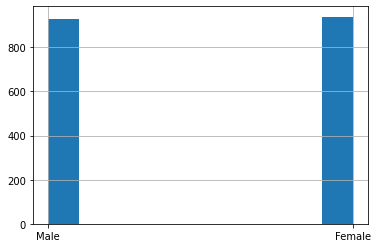

In [16]:
personal['gender'][c_non].hist()

In [17]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [18]:
personal['SeniorCitizen'].unique()

array([0, 1])

In [19]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [20]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [21]:
internet.describe()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,4910-AQFFX,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


In [22]:
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [23]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [24]:
phone['MultipleLines'].describe()

count     6361
unique       2
top         No
freq      3390
Name: MultipleLines, dtype: object

**Вывод**

На основе полученных данных можно сделать несколько выводов:

- Гендер никак не влияет на отток клиентов
- Большинство клиентов , которые рассторгнули контракт платили в месяц от 70 до 120 в месяц и по итогу общая выручка не превышала 1000, возможно данная цена не удовлетворяла покупателей и спектром услуг , которые им были доступны. 


# План работы 

- Проверка данных на дубликаты , аномалии и их решение
- Подгоитовка данных к работе с машинным обучением
- Необходимо добавить дополнителный стиолбец с количеством дней 
- Объединить первые две таблицы , удалить ненужные для обучения столбцы
- Обучение нескеольких моделей Линейная регрессия, Случайный лес и CatBoost
- Тестирование и написание выводов по проектыу

# Предобработка данных

Добавление дополнительной таблицы с количеством дней пользователя, проверка на дубликаты и аномалии 

In [25]:
r = 26122

In [26]:
data = contract[['MonthlyCharges', 'TotalCharges']]

isolation_forest = IsolationForest(n_estimators=100)
isolation_forest.fit(data)
anomaly_scores = isolation_forest.decision_function(data)

outliers = []
for i in range(len(anomaly_scores)):
    if anomaly_scores[i] == -1:
        outliers.append(i)

print("Количество аномалий: ", len(outliers))

Количество аномалий:  0


In [27]:
print("Количество дубликатов: ",contract.duplicated().sum())

Количество дубликатов:  0


In [28]:
contract['BDate'] = pd.to_datetime(
    contract['BeginDate'], format='%Y-%m-%d'
)

contract['EDate'] = contract['EndDate']
contract.loc[contract['EDate'] == 'No','EDate'] = contract['BeginDate'].max()
contract['EDate'] = pd.to_datetime(
    contract['EDate'], format='%Y-%m-%d'
)
contract['leave'] = contract['EndDate']
contract.loc[contract['leave'] != 'No','leave'] = 1
contract.loc[contract['leave'] == 'No','leave'] = 0


In [29]:
contract['Day'] = contract['EDate'] -contract['BDate']

In [30]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,BDate,EDate,leave,Day
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,2020-01-01,2020-02-01,0,31 days
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,2017-04-01,2020-02-01,0,1036 days
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,2019-10-01,2019-12-01,1,61 days
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,2016-05-01,2020-02-01,0,1371 days
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,2019-09-01,2019-11-01,1,61 days


# Объеденение таблиц 

In [31]:
contract_m = contract.merge(personal, on='customerID')
contract_m

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,BDate,EDate,leave,Day,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,2020-01-01,2020-02-01,0,31 days,Female,0,Yes,No
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,2017-04-01,2020-02-01,0,1036 days,Male,0,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,2019-10-01,2019-12-01,1,61 days,Male,0,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,2016-05-01,2020-02-01,0,1371 days,Male,0,No,No
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,2019-09-01,2019-11-01,1,61 days,Female,0,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.50,2018-02-01,2020-02-01,0,730 days,Male,0,Yes,Yes
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.90,2014-02-01,2020-02-01,0,2191 days,Female,0,Yes,Yes
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45,2019-03-01,2020-02-01,0,337 days,Female,0,Yes,Yes
7041,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.60,2019-07-01,2019-11-01,1,123 days,Male,1,Yes,No


In [32]:
contract_1 = contract_m.drop(['customerID','EndDate','BeginDate','BDate','EDate'],axis=1)
contract_1['leave'] = contract_1['leave'].astype(int)
contract_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype          
---  ------            --------------  -----          
 0   Type              7043 non-null   object         
 1   PaperlessBilling  7043 non-null   object         
 2   PaymentMethod     7043 non-null   object         
 3   MonthlyCharges    7043 non-null   float64        
 4   TotalCharges      7043 non-null   float64        
 5   leave             7043 non-null   int64          
 6   Day               7043 non-null   timedelta64[ns]
 7   gender            7043 non-null   object         
 8   SeniorCitizen     7043 non-null   int64          
 9   Partner           7043 non-null   object         
 10  Dependents        7043 non-null   object         
dtypes: float64(2), int64(2), object(6), timedelta64[ns](1)
memory usage: 660.3+ KB


In [33]:
contract_1.corr()

,MonthlyCharges,TotalCharges,leave,SeniorCitizen
MonthlyCharges,1.000000,0.651182,0.193356,0.220173
TotalCharges,0.651182,1.000000,-0.198347,0.102997
leave,0.193356,-0.198347,1.000000,0.150889
SeniorCitizen,0.220173,0.102997,0.150889,1.000000


Разделение на выборки

In [34]:
features_train, features_valid, target_train, target_valid = train_test_split(
    contract_1.drop('leave', axis=1), contract_1.leave, test_size=0.25, random_state=r)

**Модель CatBoost**

In [35]:
cat_features = ['Type', 'PaperlessBilling', 'PaymentMethod',
                'Day','gender','Partner','Dependents']

cv_dataset = Pool(data=features_train,
                  label=target_train,
                  cat_features=cat_features)

params = {"iterations": 1500,
          'custom_loss': 'AUC',
          "verbose": False,
          'loss_function': 'Logloss',
          'random_state' : r
          }

scores = cv(cv_dataset,
            params,
            fold_count=3,
            
           shuffle=True,
            plot="True")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/3]

bestTest = 0.2201798246
bestIteration = 158

Training on fold [1/3]

bestTest = 0.20497187
bestIteration = 417

Training on fold [2/3]

bestTest = 0.2079503442
bestIteration = 352



Самая лучшая метрика из графика показана при ззначении иттераций 198

**Модель RandomForestRegressor**

Применение OrdinalEncoder для модели RandomForestRegressor

In [36]:
encoder = OrdinalEncoder(handle_unknown='ignore')

cat_columns = ['Type', 'PaperlessBilling', 'PaymentMethod',
                'Day','gender','Partner','Dependents']

features_train_r = features_train.copy()
features_valid_r = features_valid.copy()

features_train_r[cat_columns] = encoder.fit_transform(features_train[cat_columns])
features_valid_r[cat_columns] = encoder.transform(features_valid[cat_columns])

In [37]:
best_depth = 0
best_result = -100000000

for depth in range(1, 16, 1):
    
    model = RandomForestRegressor(n_estimators=20,max_depth=depth,random_state=r)

    scores = cross_val_score(model,features_train_r, target_train, cv=5,scoring= 'roc_auc')
    if scores.mean() > best_result:
        best_depth = depth
        
        best_result = scores.mean()
            
print(best_depth,best_result)

7 0.8632316459437475


При данной модели получилась хороший результат метрики , но у CatBoost значения лучше

**Модель LogisticRegression**

In [38]:
features_train_l = pd.get_dummies(features_train)
features_train_l['Day'] = features_train_l['Day'].dt.days
pd.options.mode.chained_assignment = None
scaler = StandardScaler()
scaler.fit(features_train_l)
features_train_l = scaler.transform(features_train_l)

In [39]:
ohe_features_ridge = features_train.select_dtypes(include='object').columns.to_list()
print(ohe_features_ridge)

['Type', 'PaperlessBilling', 'PaymentMethod', 'gender', 'Partner', 'Dependents']


In [40]:
num_features = features_train.select_dtypes(exclude='object').columns.to_list()
num_features

['MonthlyCharges', 'TotalCharges', 'Day', 'SeniorCitizen']

In [41]:
features_train_l = features_train.copy()
features_train_l['Day'] = features_train_l['Day'].dt.days
X_train_ridge = features_train_l.copy()

In [42]:
# drop='first' удаляет первый признак из закодированных:
# таким образом обходим dummy-ловушку
# задаём handle_unknown='ignore':
# игнорируется ранее невстречающиеся значения признака (при transform)
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='error', sparse=False)

# обучаем энкодер на заданных категориальных признаках тренировочной выборки
encoder_ohe.fit(X_train_ridge[ohe_features_ridge])

# добавляем закодированные признаки в X_train_ohe
# encoder_ohe.get_feature_names_out() позволяет получить названия колонок
X_train_ridge[
    encoder_ohe.get_feature_names()
] = encoder_ohe.transform(X_train_ridge[ohe_features_ridge])

# удаляем незакодированные категориальные признаки (изначальные колонки)
X_train_ridge = X_train_ridge.drop(ohe_features_ridge, axis=1)

# создаём скелер
scaler = StandardScaler()

# обучаем его на численных признаках тренировочной выборки, трансформируем её же
X_train_ridge[num_features] = scaler.fit_transform(X_train_ridge[num_features])

# смотрим на результат
X_train_ridge.head()

,MonthlyCharges,TotalCharges,Day,SeniorCitizen,x0_One year,x0_Two year,x1_Yes,x2_Credit card (automatic),x2_Electronic check,x2_Mailed check,x3_Male,x4_Yes,x5_Yes
6462,1.022879,-0.930099,-1.233601,-0.440695,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
5635,-0.335408,-0.484709,-0.419101,-0.440695,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
5576,-0.373553,-0.980189,-1.274994,-0.440695,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
6545,0.326322,-0.693962,-0.947859,-0.440695,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
5370,0.862007,-0.368699,-0.663451,-0.440695,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0


In [43]:
best_depth = 0
best_result = -100000000

for it in range(1, 33, 5):
    
    model = LogisticRegressionCV(random_state=r, solver='liblinear', cv = 5,max_iter = it)
      

    scores = cross_val_score(model,X_train_ridge, target_train, cv=5,scoring= 'roc_auc')
    if scores.mean() > best_result:
        best_depth = depth
        
        best_result = scores.mean()

    
            
print(best_depth,best_result)

15 0.8356274830851383


Данная модель показала хороший результат, но из всех остальных этот результат самый низкий

# Проверка модели

In [44]:
cat_features = ['Type', 'PaperlessBilling', 'PaymentMethod',
                'Day','gender','Partner','Dependents']

model = CatBoostClassifier(loss_function="Logloss", iterations=198,random_state = r)

model.fit(features_train, target_train, cat_features=cat_features, verbose=False)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
roc_auc_score(target_valid, probabilities_one_valid)

0.9414497647090101

# Исследование важности признаков лучшей модели


In [45]:
print(confusion_matrix(target_valid,model.predict(features_valid)))

[[1257   40]
 [ 133  331]]


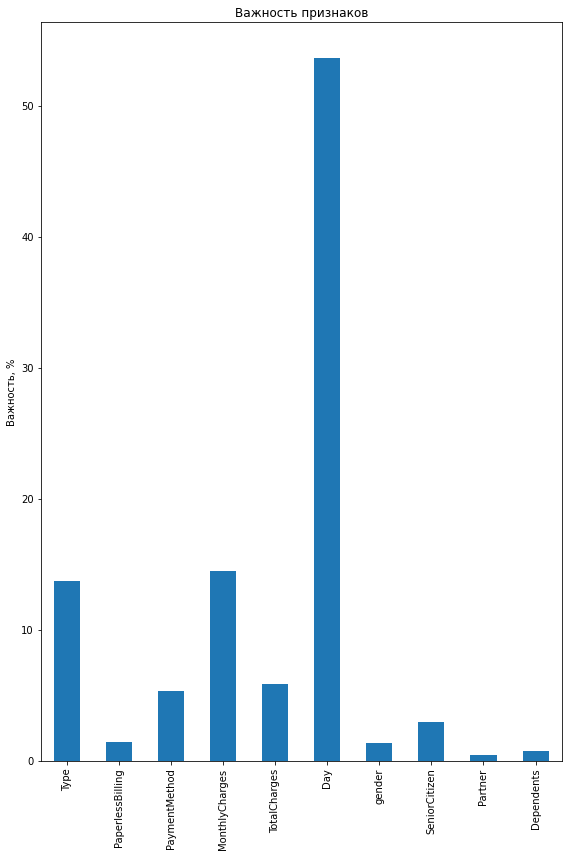

In [46]:
cat_iris_imp = pd.Series(model.get_feature_importance(),
                         features_train.columns)
fig, ax = plt.subplots(figsize=(8,12))
cat_iris_imp.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность, %')
fig.tight_layout()

Лучшею метрику на кросс валидации показала CatBoost , достигнув на тестовой выборке значений ROC-AUC 0.94 выше на грпафике приведена зависимость конкретных признаков на предмсказание моджли , первое место занимает количество дней, на втором месте ежемесячные выплаты и третье место тип договора. Если обратить внимание на матрицу ошибок , то модель чаще ошибалась с клиентами , которые должны били расторгнуть договор , но этого не сделали.

# Отчет

- В результате проверки данных не было обнаружено дубликатов и аномалий
- Подготовили данные для работы с различными моделями
- Добавили дополнительный столбец с количеством дней  действия договора клиента
- Произвели объединение первых двух таблиц, произвели удаление столбцов , которые не нужны для обучения моджели
- Обучили нескеолько моделей: Линейная регрессия, Случайный лес и CatBoost и получили значение метрик ROC-AUC по каждой из них
- Протестировали лучшую модель на тестовой выборки и получили итоговое значение метрики равной 0.94



Все данные, с которыми мы работали не имели специфических значений , поэтому особых трудностей при выполнении работы не возникло.

Ключевыми шагами в написании работы можно выделить следующие этапы:
- Обработка данных 
- Подгатовка признаков для моделей
- Обучение моделей

Лучшей моделью является CatBoost , на валлидационной выборке подобрали лучшее значение гиперпараметра количества иттераций равный 198. Для этой модели мы подготовили данные заменив пропуски в с толбце TotalCharges, значениями из столбца MonthlyCharges. Данные для этой модели не кодировались , так как модель использует свои встроенные внутренние методы.

Список признаков:
- Type, использовался без обработки
- PaperlessBilling, использовался без обработки
- PaymentMethod, использовался без обработки
- MonthlyCharges, использовался без обработки
- TotalCharges, были заполнены пропуски 
- Day, новый столбец, он был получен из разности BeginDate и EndDate, значения 'No' в столбце EndDate заменили на '2020-02-01'
- gender, использовался без обработки
- SeniorCitizen, использовался без обработки
- Partner, использовался без обработки
- Dependents, использовался без обработки